# Classify Oct4 and Mafk binding sites

In this tutorial we fit a simple model to distinguish Oct4 from Mafk bound sites obtained from ChIP-seq experiments.

In [1]:
import os
import numpy as np
import pandas as pd
import pkg_resources

from keras import backend as K
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Maximum

from janggu import Janggu
from janggu import Scorer
from janggu import inputlayer
from janggu import outputdense
from janggu.data import Array
from janggu.data import Bioseq
from janggu.layers import Complement
from janggu.layers import DnaConv2D
from janggu.layers import Reverse
from janggu.utils import ExportClustermap
from janggu.utils import ExportTsv

import matplotlib

np.random.seed(1234)

from IPython.display import Image

/home/wkopp/anaconda3/envs/jdev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next we chose the output directory, the sequence feature order and the whether to use a model that scans only the forward strand or
a model that scans both strands simultaneously.

In [2]:
modeltype = 'dnaconv'
#modeltype = 'double'
#modeltype = 'single'
order = 3

modeltype 'dnaconv' and 'double' both scan the DNA sequence on both strands for motif occurrences, while 'single' only scans the forward strand.

Next we set the JANGGU_OUTPUT environment variable, which defines the folder in which all results are stored.

In [3]:
os.environ['JANGGU_OUTPUT'] = '/home/wkopp/janggu_examples'

We use the following input files for the example:

In [4]:
# load the dataset
DATA_PATH = pkg_resources.resource_filename('janggu', 'resources/')
OCT4 = os.path.join(DATA_PATH, 'sample.fa')
MAFK = os.path.join(DATA_PATH, 'sample2.fa')

OCT4_TEST = os.path.join(DATA_PATH, 'sample_test.fa')
MAFK_TEST = os.path.join(DATA_PATH, 'sample2_test.fa')

The DNA sequences, which are used as input for the models, can be loaded using into a Bioseq dataset object

In [5]:
DNA = Bioseq.create_from_seq('dna', fastafile=[OCT4, MAFK],
                             order=order, cache=True)
DNA_TEST = Bioseq.create_from_seq('dna', fastafile=[OCT4_TEST, MAFK_TEST],
                                  order=order, cache=True)


reload /home/wkopp/janggu_examples/datasets/dna/a670d5c6da22d5d11af94e663efe095ba034ce12572ef36bb74e1d94e915b397.npz
reload /home/wkopp/janggu_examples/datasets/dna/b39e8ad5fe7ba00222dce88d0c41fff742422292deb21698862e27f0d06af087.npz


The output labels for the training and test set can be obtained as follows

In [6]:
# helper function
def nseqs(filename):
    """This function extracts the number of sequences
    from the fasta file.
    """
    return sum((1 for line in open(filename) if line[0] == '>'))

Y = np.asarray([[1] for line in range(nseqs(OCT4))] +
               [[0] for line in range(nseqs(MAFK))])
LABELS = Array('y', Y, conditions=['TF-binding'])

Y = np.asarray([[1] for _ in range(nseqs(OCT4_TEST))] +
               [[0] for _ in range(nseqs(MAFK_TEST))])
LABELS_TEST = Array('y', Y, conditions=['TF-binding'])


Next, we define three different network topologies using the Janggu framework. The first one considers only the forward strand, whereas the latter two scan both DNA strands for motif matches.

In [7]:

@inputlayer
@outputdense('sigmoid')
def single_stranded_model(inputs, inp, oup, params):
    """ keras model that scans a DNA sequence using
    a number of motifs.

    This model only scans one strand for sequence patterns.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        layer = Conv2D(params[0], (params[1], 1), activation=params[2])(layer)
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output

In [8]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    Sequence patterns may be present on either strand.
    By scanning both DNA strands with the same motifs (kernels)
    the performance of the model will generally improve.

    In the model below, this is achieved by reverse complementing
    the input tensor and keeping the convolution filters fixed.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        forward = layer
    convlayer = Conv2D(params[0], (params[1], 1), activation=params[2])
    revcomp = Reverse()(forward)
    revcomp = Complement()(revcomp)

    forward = convlayer(forward)
    revcomp = convlayer(revcomp)
    revcomp = Reverse()(revcomp)
    layer = Maximum()([forward, revcomp])
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output


In [9]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model_dnaconv(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    A more elegant way of scanning both strands for motif occurrences
    is achieved by the DnaConv2D layer wrapper, which internally
    performs the convolution operation with the normal kernel weights
    and the reverse complemented weights.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        conv = DnaConv2D(Conv2D(params[0],
                                (params[1], 1),
                                activation=params[2]), name='conv1')(layer)

    output = GlobalAveragePooling2D(name='motif')(conv)
    return inputs, output

In [10]:
if modeltype == 'single':
    modeltemplate = single_stranded_model
elif modeltype == 'double':
    modeltemplate = double_stranded_model
else:
    modeltemplate = double_stranded_model_dnaconv

K.clear_session()

Instantiate a new model.

In [11]:
modelname = 'fasta_seqs_m{}_o{}'.format(modeltype, order)

In [12]:
# create a new model object
model = Janggu.create(template=modeltemplate,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=LABELS,
                      name=modelname)

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dna (InputLayer)             (None, 198, 1, 64)        0         
_________________________________________________________________
conv1 (DnaConv2D)            (None, 178, 1, 30)        40350     
_________________________________________________________________
motif (GlobalAveragePooling2 (None, 30)                0         
_________________________________________________________________
y (Dense)                    (None, 1)                 31        
Total params: 40,381
Trainable params: 40,381
Non-trainable params: 0
_________________________________________________________________


And train it

In [13]:
# fit the model
hist = model.fit(DNA, LABELS, epochs=100)

Epoch 1/100
244/244 [==============================] - 4s 15ms/step - loss: 0.6248 - acc: 0.6492
Epoch 2/100
244/244 [==============================] - 2s 9ms/step - loss: 0.5205 - acc: 0.7728
Epoch 3/100
244/244 [==============================] - 2s 10ms/step - loss: 0.4627 - acc: 0.7983
Epoch 4/100
244/244 [==============================] - 2s 10ms/step - loss: 0.4228 - acc: 0.8209
Epoch 5/100
244/244 [==============================] - 3s 11ms/step - loss: 0.3940 - acc: 0.8334
Epoch 6/100
244/244 [==============================] - 2s 10ms/step - loss: 0.3690 - acc: 0.8452
Epoch 7/100
244/244 [==============================] - 3s 10ms/step - loss: 0.3471 - acc: 0.8573
Epoch 8/100
244/244 [==============================] - 3s 10ms/step - loss: 0.3261 - acc: 0.8656
Epoch 9/100
244/244 [==============================] - 2s 10ms/step - loss: 0.3049 - acc: 0.8775
Epoch 10/100
244/244 [==============================] - 3s 10ms/step - loss: 0.2845 - acc: 0.8881
Epoch 11/100
244/244 [========

244/244 [==============================] - 2s 9ms/step - loss: 0.0190 - acc: 0.9981
Epoch 86/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0185 - acc: 0.9985
Epoch 87/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0179 - acc: 0.9987
Epoch 88/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0173 - acc: 0.9986
Epoch 89/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0169 - acc: 0.9987
Epoch 90/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0164 - acc: 0.9987
Epoch 91/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0162 - acc: 0.9986
Epoch 92/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0158 - acc: 0.9994
Epoch 93/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0151 - acc: 0.9991
Epoch 94/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0148 - acc: 0.9994
Epoch 95/100
244/244 [=====================

Finally, we can evaluate various performance measures, including the area under the ROC curve or the area under the precision recall curve.

[0.09514768898487092, 0.96]

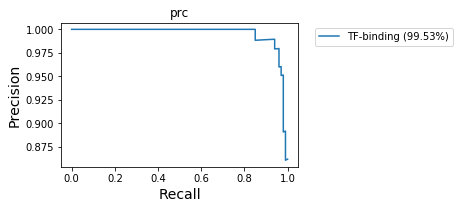

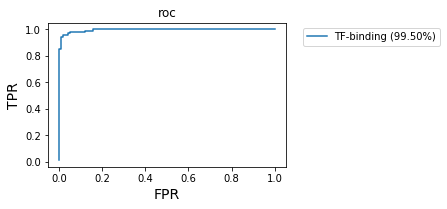

In [14]:
model.evaluate(DNA_TEST, LABELS_TEST, datatags=['test'],
               callbacks=['prc', 'auprc', 'roc', 'auroc'])

The results of this evaluation can be found in the output folder

In [15]:
evaluation_folder = os.path.join(os.environ['JANGGU_OUTPUT'], 'evaluation', modelname, 'test')

It contains summary figures of the PRC and ROC curve

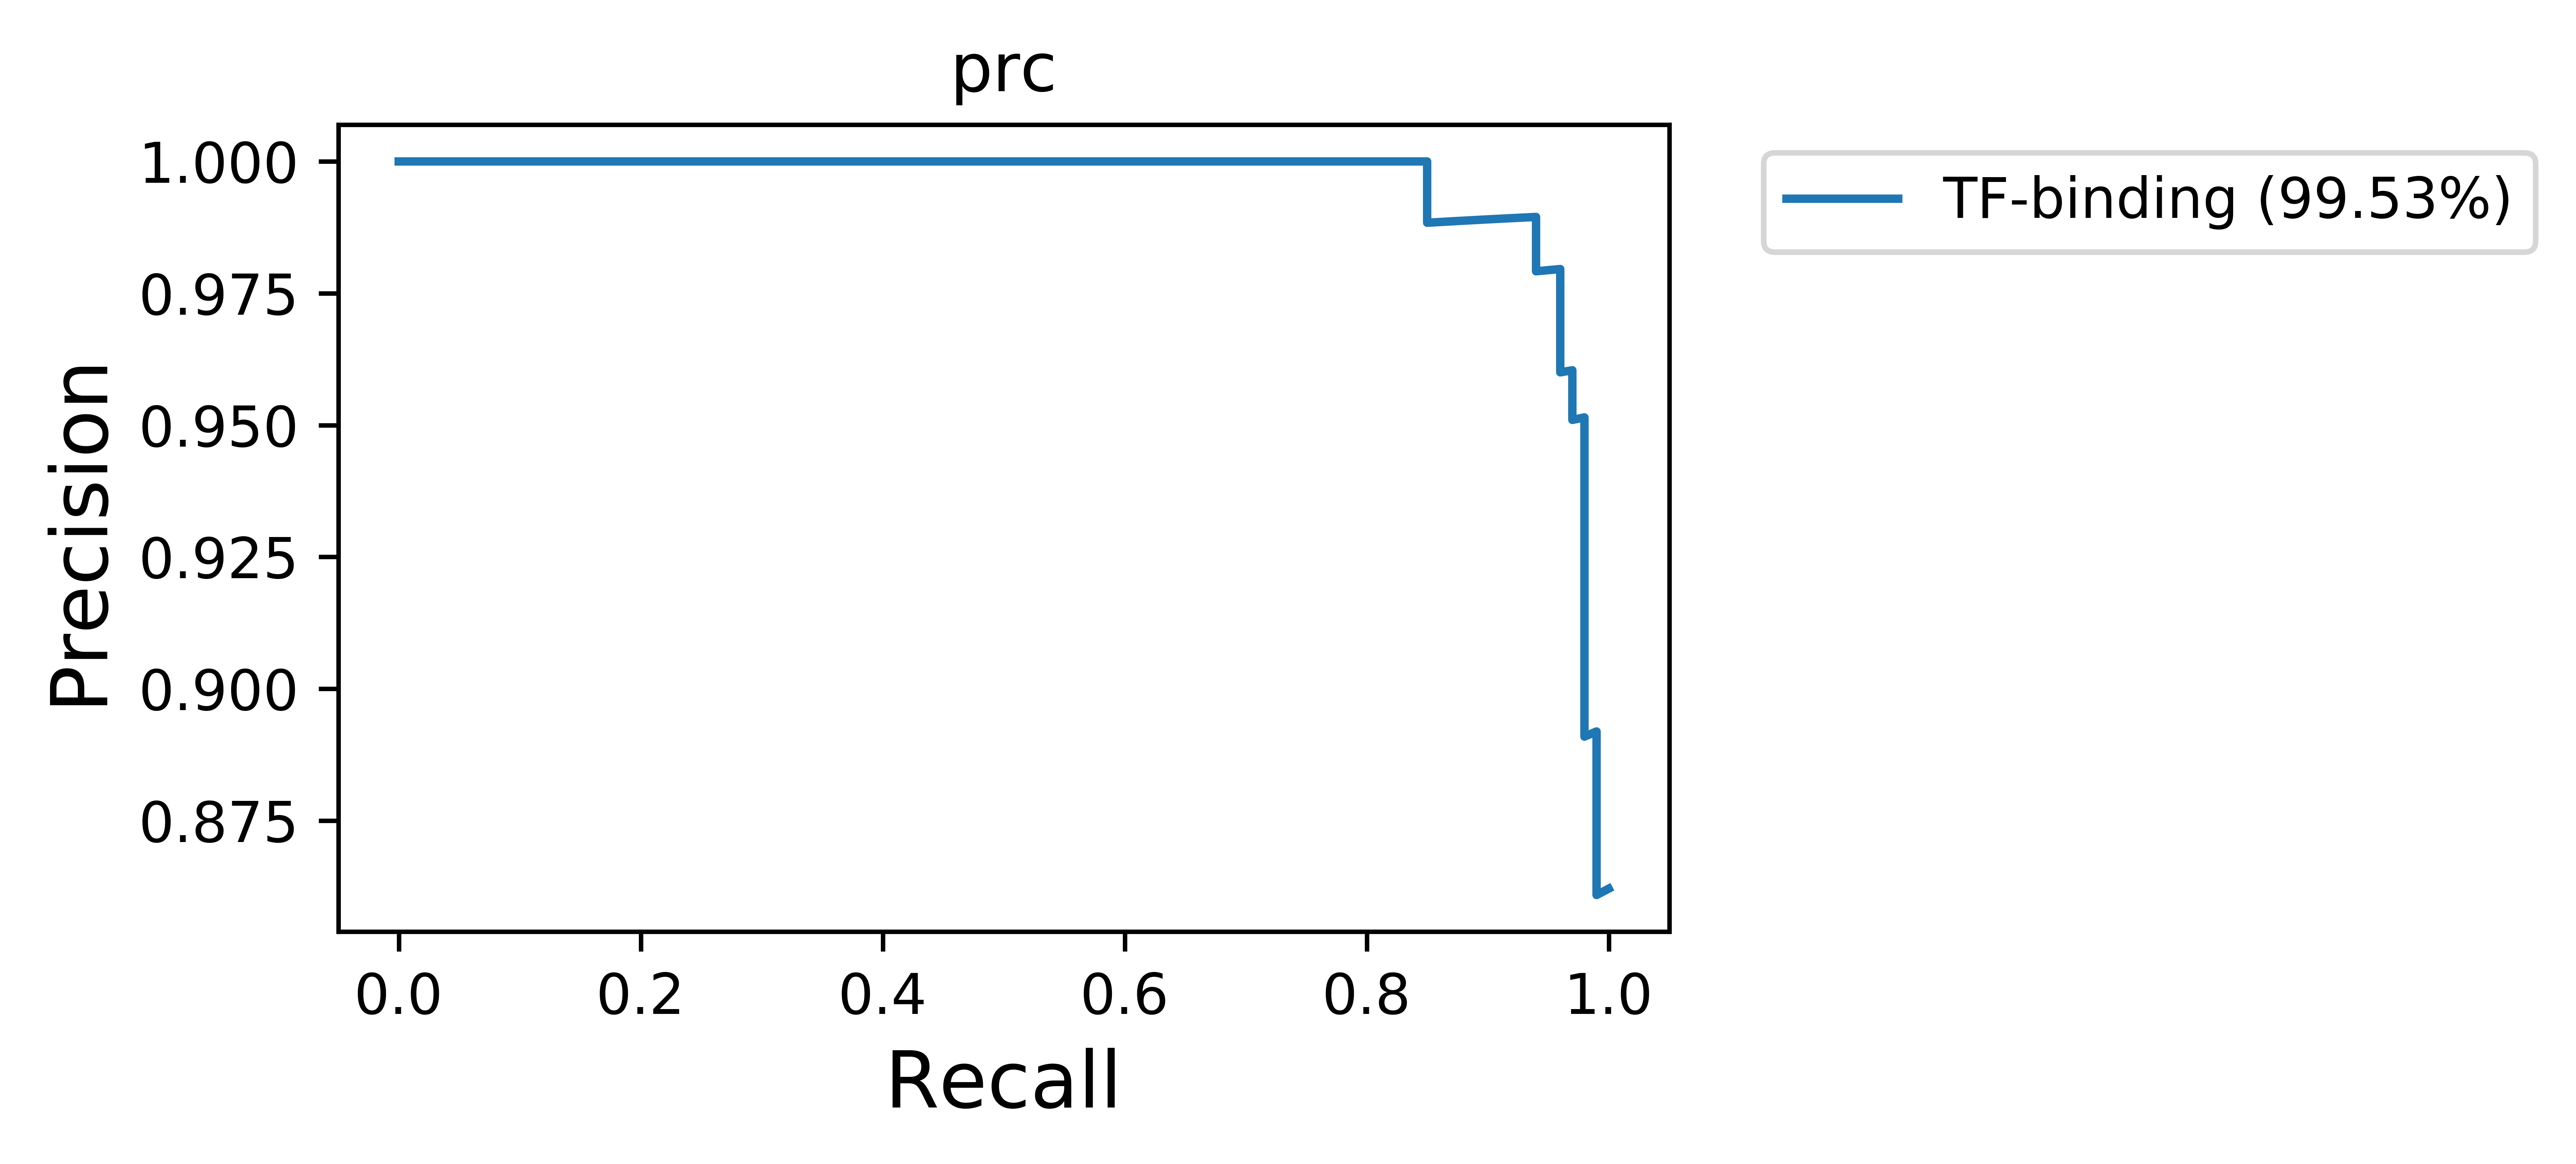

In [16]:
Image(os.path.join(evaluation_folder, 'prc.png'))

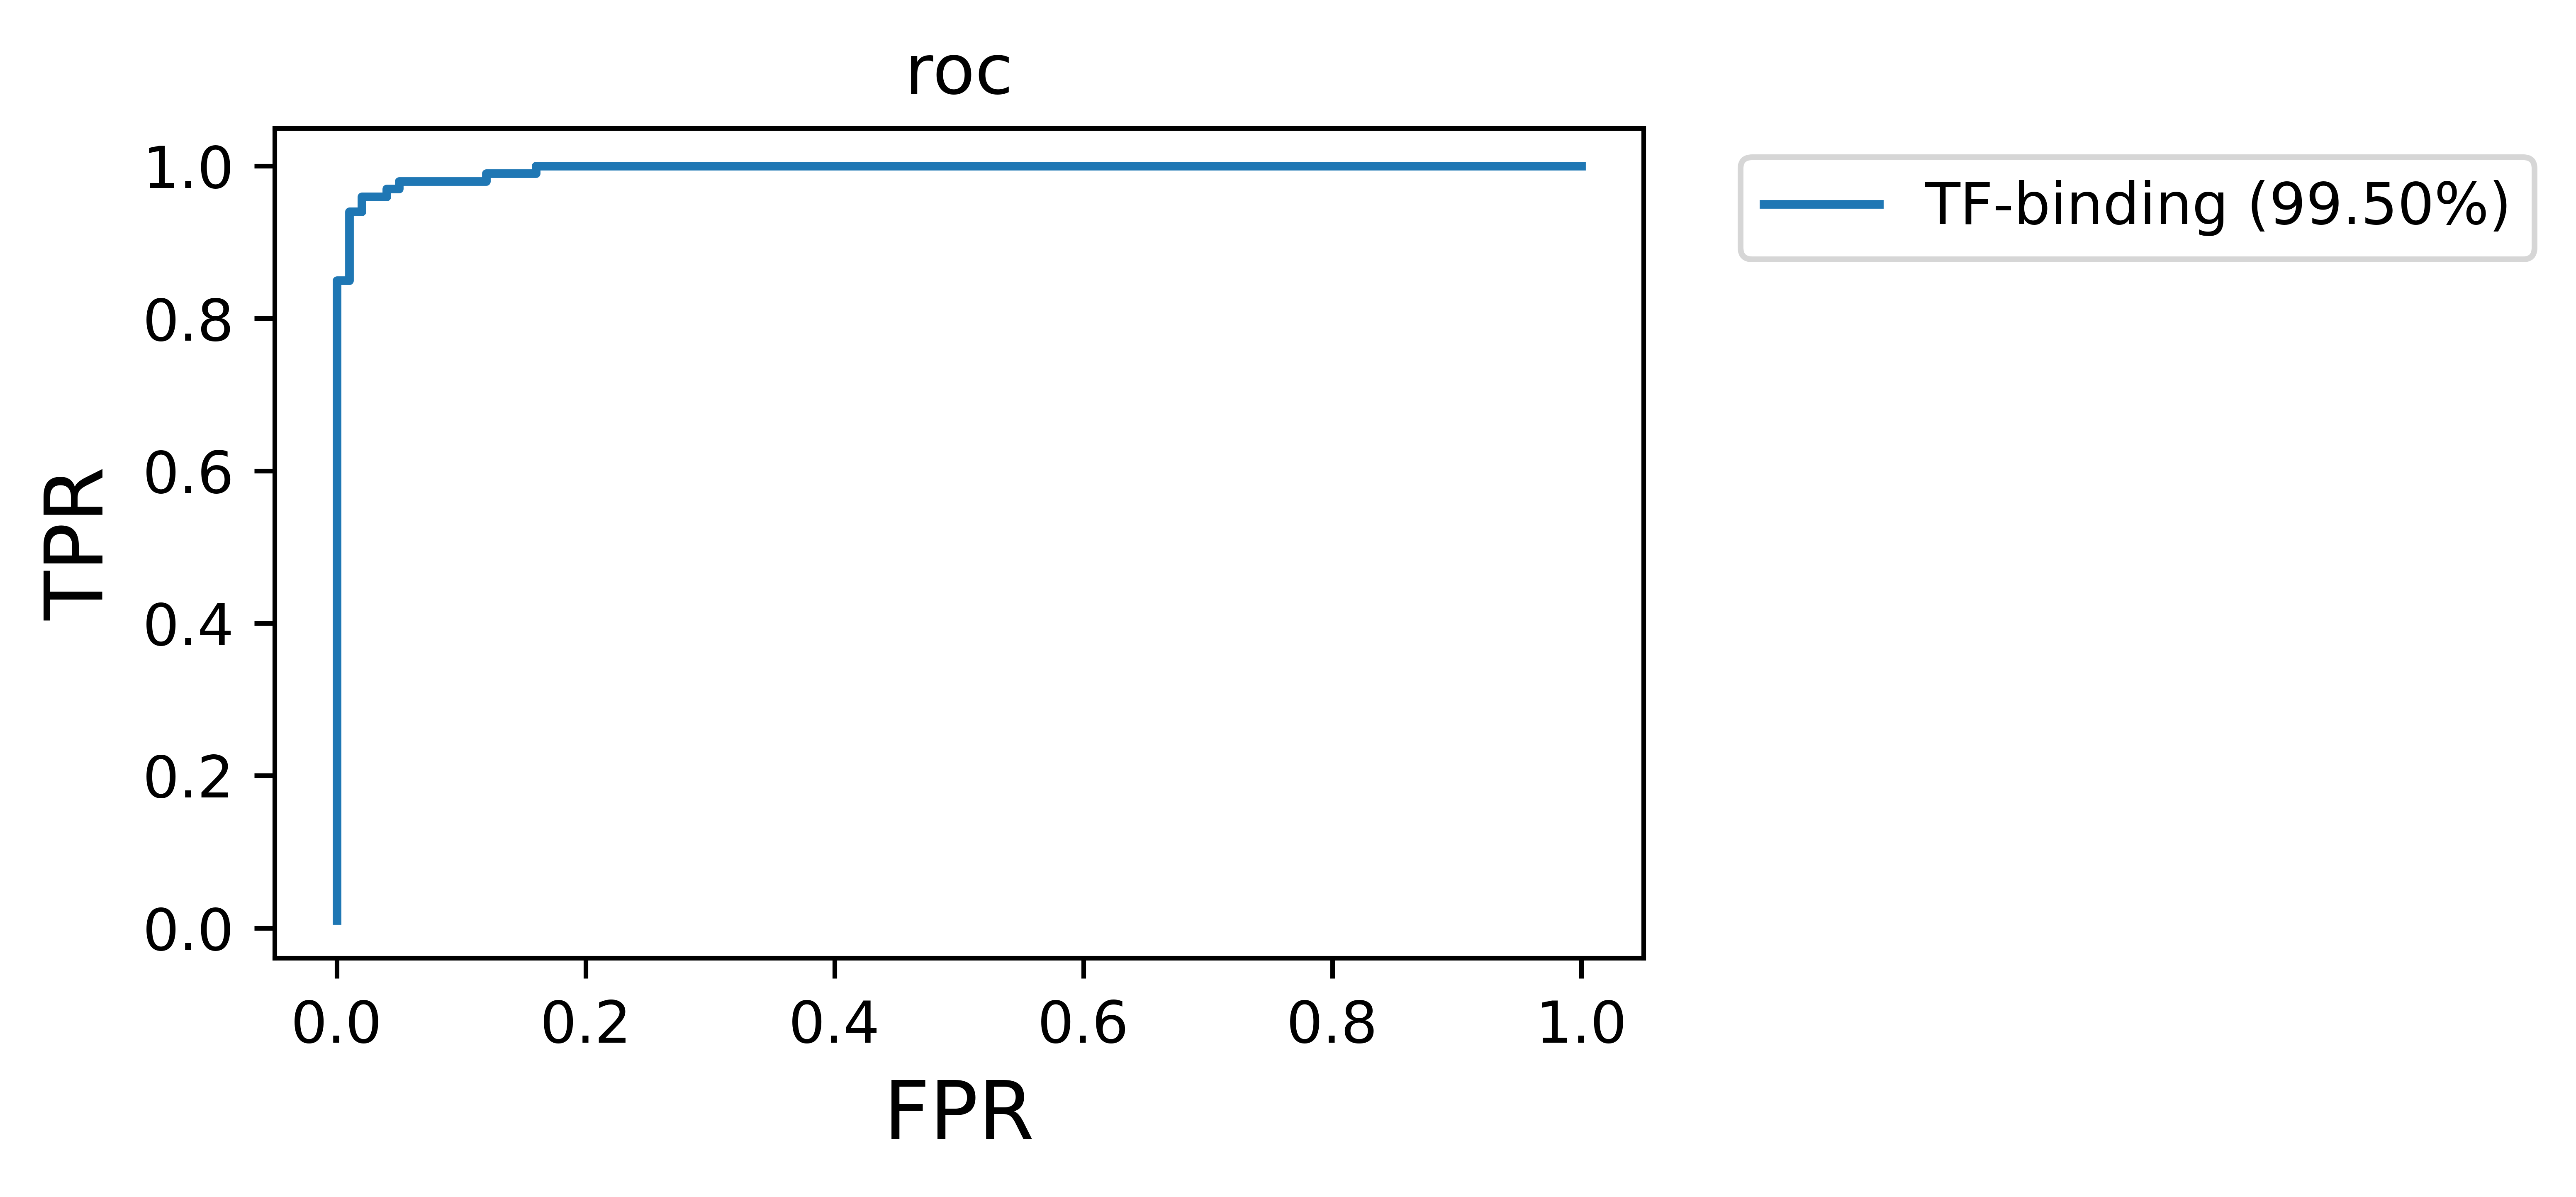

In [17]:
Image(os.path.join(evaluation_folder, 'roc.png'))

The scores are also exported in table form

In [18]:
pd.read_csv(os.path.join(evaluation_folder, 'auprc.tsv'))

,TF-binding
0,0.995258


In [19]:
pd.read_csv(os.path.join(evaluation_folder, 'auroc.tsv'))

,TF-binding
0,0.995
